<a href="https://colab.research.google.com/github/KwonHo-geun/AI_Study/blob/main/25.08.06_StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def dfs_recursive_helper(grid, current, goal, visited, path_order):
    rows, cols = len(grid), len(grid[0])
    row, col = current

    # 종료 조건 1: 그리드 밖이거나 벽인 경우
    if not (0 <= row < rows and 0 <= col < cols and grid[row][col] == 0):
      return False
    # 종료 조건 2: 이미 방문한 경우
    if current in visited:
      return False
    # 현재 노드 방문 처리
    visited.add(current)
    path_order.append(current)

    # 종료 조건 3: 목표 도달
    if current == goal:
      return True

    # 재귀 단계: 4방향 이웃에 대해 재귀 호출
    for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]: # 우, 하, 좌, 상
        if dfs_recursive_helper(grid, (row + dr, col + dc), goal, visited, path_order):
            return True

    return False

In [ ]:
# 벨만-포드 함수 구현 및 실행

def bellman_ford(edges, num_v, source):
    # 1. 거리 초기화
    distances = [float('inf')] * num_v
    distances[source] = 0

    # 2. V-1 번 반복하며 엣지 완화
    for i in range(num_v - 1):
        print(f"--- 반복 {i+1} ---")
        for u, v, w in edges:
            # [문제] 만약 노드 u까지의 현재 거리가 무한대가 아니고,
            # 노드 u까지의 거리에 u에서 v로 가는 엣지의 가중치 w를 더한 값이
            # 노드 v까지의 현재 거리보다 작다면
            if distances[u] != float('inf') and distances[u] + w < distances[v]:
                print(f"  (엣지 {u}->{v}) 노드 {v}의 거리 갱신: {distances[v]:.2f} -> {distances[u] + w:.2f}")
                # 문제]  노드 v까지의 최단 거리를 이 새로운, 더 짧은 거리로 업데이트하라
                distances[v] = distances[u] + w
        print(f"  현재 거리: {[f'{d:.2f}' for d in distances]}")

    return distances

# 벨만-포드 알고리즘 실행
shortest_distances = bellman_ford(edges, num_vertices, source_node)

print("\n--- 최종 결과 ---")
for i, dist in enumerate(shortest_distances):
    print(f"시작 노드 {source_node}에서 노드 {i}까지의 최단 거리: {dist}")

In [ ]:
def execute_policy(policy, start):
    row, col = start
    path = [(row, col)]

    # 최대 20번만 이동하도록 제한 (무한 루프 방지)
    for _ in range(20):
        # [문제] 현재 에이전트가 있는 위치의 정책(가야 할 방향)을 확인합니다.
        action = policy[row][col]

        # [문제] 만약 현재 위치가 'G' (목표 지점)이면
        if action == 'G':
            # [문제] "목표 도달!" 이라고 출력하고
            print("목표 도달!")
            # [문제] 지금까지 지나온 길(경로)을 반환하고 함수를 끝냅니다.
            return path

        # [문제] 만약 정책이 '>' (오른쪽)이면, 오른쪽으로 한 칸 이동합니다.
        if action == '>': col += 1
        # [문제] 아니면 만약 정책이 '<' (왼쪽)이면, 왼쪽으로 한 칸 이동합니다.
        elif action == '<': col -= 1
        # [문제] 아니면 만약 정책이 'v' (아래쪽)이면, 아래쪽으로 한 칸 이동합니다.
        elif action == 'v': row += 1
        # [문제] 그 외에 만약 정책이 '^' (위쪽)이면, # 위쪽으로 한 칸 이동합니다.
        elif action == '^': row -= 1

        path.append((row, col))

    print("경로를 찾지 못했거나 너무 오래 걸렸습니다.")
    return path

In [1]:
# Get prerequisites
!pip install ninja
!gdown https://drive.google.com/uc?id=1KI8iH_5cMxptYiKkDE7oN0Xi1dHYChO1

!unzip op.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 8.7 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1KI8iH_5cMxptYiKkDE7oN0Xi1dHYChO1
To: /content/op.zip
100% 9.39k/9.39k [00:00<00:00, 28.1MB/s]
Archive:  op.zip
  inflating: op/__init__.py          
  inflating: op/conv2d_gradfix.py    
  inflating: op/fused_act.py         
  inflating: op/fused_bias_act.cpp   
  inflating: op/fused_bias_act_kernel.cu  
  inflating: op/upfirdn2d.cpp        
  inflating: op/upfirdn2d.py         
  inflating: op/upfirdn2d_kernel.cu  


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-01ba01ca-8e1b-81a8-b6c6-d1b777d5ad39)


In [3]:
# Import libraries and modules
import os

import math
import random
import functools
import operator

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Function
import torchvision

import numpy as np
import matplotlib.pyplot as plt

from op import FusedLeakyReLU, fused_leaky_relu, upfirdn2d, conv2d_gradfix

# Fix seed(42) - 상징적인 숫자
torch.manual_seed(42)
random.seed(42)

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [4]:
class PixelNorm(nn.Module): #학습 안정화
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.rsqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)

def make_kernel(k): #kernel 정규화 : 합이 1이 되도록
    k = torch.tensor(k, dtype=torch.float32)

    if k.ndim == 1:
        k = k[None, :] * k[:, None]

    k /= k.sum()

    return k

class Upsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel) * (factor ** 2)
        self.register_buffer("kernel", kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2 + factor - 1
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=self.factor, down=1, pad=self.pad)

        return out


class Downsample(nn.Module):
    def __init__(self, kernel, factor=2):
        super().__init__()

        self.factor = factor
        kernel = make_kernel(kernel)
        self.register_buffer("kernel", kernel)

        p = kernel.shape[0] - factor

        pad0 = (p + 1) // 2
        pad1 = p // 2

        self.pad = (pad0, pad1)

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, up=1, down=self.factor, pad=self.pad)

        return out


class Blur(nn.Module):
    def __init__(self, kernel, pad, upsample_factor=1):
        super().__init__()

        kernel = make_kernel(kernel)

        if upsample_factor > 1:
            kernel = kernel * (upsample_factor ** 2)

        self.register_buffer("kernel", kernel)

        self.pad = pad

    def forward(self, input):
        out = upfirdn2d(input, self.kernel, pad=self.pad)

        return out

In [5]:
class EqualConv2d(nn.Module): #Equalized Learning Rate - W-scaled = W/루트 n (where n = channel * k_size(제곱))
    def __init__(
        self, in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True
    ):
        super().__init__()

        self.weight = nn.Parameter(
            torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        )
        self.scale = 1 / math.sqrt(in_channel * kernel_size ** 2)

        self.stride = stride
        self.padding = padding

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channel))

        else:
            self.bias = None

    def forward(self, input):
        out = conv2d_gradfix.conv2d( #보정함수
            input,
            self.weight * self.scale,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
        )

        return out

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]},"
            f" {self.weight.shape[2]}, stride={self.stride}, padding={self.padding})"
        )

class EqualLinear(nn.Module):
    def __init__(
        self, in_dim, out_dim, bias=True, bias_init=0, lr_mul=1, activation=None
    ):
        super().__init__()

        self.weight = nn.Parameter(torch.randn(out_dim, in_dim).div_(lr_mul))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim).fill_(bias_init))

        else:
            self.bias = None

        self.activation = activation

        self.scale = (1 / math.sqrt(in_dim)) * lr_mul
        self.lr_mul = lr_mul

    def forward(self, input):
        if self.activation:
            out = F.linear(input, self.weight * self.scale)
            out = fused_leaky_relu(out, self.bias * self.lr_mul)

        else:
            out = F.linear(
                input, self.weight * self.scale, bias=self.bias * self.lr_mul
            )

        return out

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.weight.shape[1]}, {self.weight.shape[0]})"
        )

class ModulatedConv2d(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        demodulate=True,
        upsample=False,
        downsample=False,
        blur_kernel=[1, 3, 3, 1],
        fused=True,
    ):
        super().__init__()

        self.eps = 1e-8
        self.kernel_size = kernel_size
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.upsample = upsample
        self.downsample = downsample

        if upsample:
            factor = 2
            p = (len(blur_kernel) - factor) - (kernel_size - 1)
            pad0 = (p + 1) // 2 + factor - 1
            pad1 = p // 2 + 1

            self.blur = Blur(blur_kernel, pad=(pad0, pad1), upsample_factor=factor)

        if downsample:
            factor = 2
            p = (len(blur_kernel) - factor) + (kernel_size - 1)
            pad0 = (p + 1) // 2
            pad1 = p // 2

            self.blur = Blur(blur_kernel, pad=(pad0, pad1))

        fan_in = in_channel * kernel_size ** 2
        self.scale = 1 / math.sqrt(fan_in)
        self.padding = kernel_size // 2

        self.weight = nn.Parameter(
            torch.randn(1, out_channel, in_channel, kernel_size, kernel_size)
        )

        self.modulation = EqualLinear(style_dim, in_channel, bias_init=1)

        self.demodulate = demodulate
        self.fused = fused

    def __repr__(self):
        return (
            f"{self.__class__.__name__}({self.in_channel}, {self.out_channel}, {self.kernel_size}, "
            f"upsample={self.upsample}, downsample={self.downsample})"
        )

    def forward(self, input, style):
        batch, in_channel, height, width = input.shape

        if not self.fused:
            weight = self.scale * self.weight.squeeze(0)
            style = self.modulation(style)

            if self.demodulate:
                w = weight.unsqueeze(0) * style.view(batch, 1, in_channel, 1, 1)
                dcoefs = (w.square().sum((2, 3, 4)) + 1e-8).rsqrt()

            input = input * style.reshape(batch, in_channel, 1, 1)

            if self.upsample:
                weight = weight.transpose(0, 1)
                out = conv2d_gradfix.conv_transpose2d(
                    input, weight, padding=0, stride=2
                )
                out = self.blur(out)

            elif self.downsample:
                input = self.blur(input)
                out = conv2d_gradfix.conv2d(input, weight, padding=0, stride=2)

            else:
                out = conv2d_gradfix.conv2d(input, weight, padding=self.padding)

            if self.demodulate:
                out = out * dcoefs.view(batch, -1, 1, 1)

            return out

        style = self.modulation(style).view(batch, 1, in_channel, 1, 1)
        weight = self.scale * self.weight * style

        if self.demodulate:
            demod = torch.rsqrt(weight.pow(2).sum([2, 3, 4]) + 1e-8)
            weight = weight * demod.view(batch, self.out_channel, 1, 1, 1)

        weight = weight.view(
            batch * self.out_channel, in_channel, self.kernel_size, self.kernel_size
        )

        if self.upsample:
            input = input.view(1, batch * in_channel, height, width)
            weight = weight.view(
                batch, self.out_channel, in_channel, self.kernel_size, self.kernel_size
            )
            weight = weight.transpose(1, 2).reshape(
                batch * in_channel, self.out_channel, self.kernel_size, self.kernel_size
            )
            out = conv2d_gradfix.conv_transpose2d(
                input, weight, padding=0, stride=2, groups=batch
            )
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)
            out = self.blur(out)

        elif self.downsample:
            input = self.blur(input)
            _, _, height, width = input.shape
            input = input.view(1, batch * in_channel, height, width)
            out = conv2d_gradfix.conv2d(
                input, weight, padding=0, stride=2, groups=batch
            )
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        else:
            input = input.view(1, batch * in_channel, height, width)
            out = conv2d_gradfix.conv2d(
                input, weight, padding=self.padding, groups=batch
            )
            _, _, height, width = out.shape
            out = out.view(batch, self.out_channel, height, width)

        return out

In [6]:
class NoiseInjection(nn.Module):
    def __init__(self):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros(1))

    def forward(self, image, noise=None):
        if noise is None:
            batch, _, height, width = image.shape
            noise = image.new_empty(batch, 1, height, width).normal_()

        return image + self.weight * noise

class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, input):
        batch = input.shape[0]
        out = self.input.repeat(batch, 1, 1, 1)

        return out

class StyledConv(nn.Module):
    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        style_dim,
        upsample=False,
        blur_kernel=[1, 3, 3, 1],
        demodulate=True,
    ):
        super().__init__()

        self.conv = ModulatedConv2d(
            in_channel,
            out_channel,
            kernel_size,
            style_dim,
            upsample=upsample,
            blur_kernel=blur_kernel,
            demodulate=demodulate,
        )

        self.noise = NoiseInjection()
        # self.bias = nn.Parameter(torch.zeros(1, out_channel, 1, 1))
        # self.activate = ScaledLeakyReLU(0.2)
        self.activate = FusedLeakyReLU(out_channel)

    def forward(self, input, style, noise=None):
        out = self.conv(input, style)
        out = self.noise(out, noise=noise)
        # out = out + self.bias
        out = self.activate(out)

        return out

class ToRGB(nn.Module):
    def __init__(self, in_channel, style_dim, upsample=True, blur_kernel=[1, 3, 3, 1]):
        super().__init__()

        if upsample:
            self.upsample = Upsample(blur_kernel)

        self.conv = ModulatedConv2d(in_channel, 3, 1, style_dim, demodulate=False)
        self.bias = nn.Parameter(torch.zeros(1, 3, 1, 1))

    def forward(self, input, style, skip=None):
        out = self.conv(input, style)
        out = out + self.bias

        if skip is not None:
            skip = self.upsample(skip)

            out = out + skip

        return out

In [7]:
class Generator(nn.Module):
    def __init__(
        self,
        size,
        style_dim,
        n_mlp,
        channel_multiplier=2,
        blur_kernel=[1, 3, 3, 1],
        lr_mlp=0.01,
    ):
        super().__init__()

        self.size = size

        self.style_dim = style_dim

        layers = [PixelNorm()]

        for i in range(n_mlp):
            layers.append(
                EqualLinear(
                    style_dim, style_dim, lr_mul=lr_mlp, activation="fused_lrelu"
                )
            )

        self.style = nn.Sequential(*layers)

        self.channels = {
            4: 512,
            8: 512,
            16: 512,
            32: 512,
            64: 256 * channel_multiplier,
            128: 128 * channel_multiplier,
            256: 64 * channel_multiplier,
            512: 32 * channel_multiplier,
            1024: 16 * channel_multiplier,
        }

        self.input = ConstantInput(self.channels[4])
        self.conv1 = StyledConv(
            self.channels[4], self.channels[4], 3, style_dim, blur_kernel=blur_kernel
        )
        self.to_rgb1 = ToRGB(self.channels[4], style_dim, upsample=False)

        self.log_size = int(math.log(size, 2))
        self.num_layers = (self.log_size - 2) * 2 + 1

        self.convs = nn.ModuleList()
        self.upsamples = nn.ModuleList()
        self.to_rgbs = nn.ModuleList()
        self.noises = nn.Module()

        in_channel = self.channels[4]

        for layer_idx in range(self.num_layers):
            res = (layer_idx + 5) // 2
            shape = [1, 1, 2 ** res, 2 ** res]
            self.noises.register_buffer(f"noise_{layer_idx}", torch.randn(*shape))

        for i in range(3, self.log_size + 1):
            out_channel = self.channels[2 ** i]

            self.convs.append(
                StyledConv(
                    in_channel,
                    out_channel,
                    3,
                    style_dim,
                    upsample=True,
                    blur_kernel=blur_kernel,
                )
            )

            self.convs.append(
                StyledConv(
                    out_channel, out_channel, 3, style_dim, blur_kernel=blur_kernel
                )
            )

            self.to_rgbs.append(ToRGB(out_channel, style_dim))

            in_channel = out_channel

        self.n_latent = self.log_size * 2 - 2

    def make_noise(self):
        device = self.input.input.device

        noises = [torch.randn(1, 1, 2 ** 2, 2 ** 2, device=device)]

        for i in range(3, self.log_size + 1):
            for _ in range(2):
                noises.append(torch.randn(1, 1, 2 ** i, 2 ** i, device=device))

        return noises

    def mean_latent(self, n_latent):
        latent_in = torch.randn(
            n_latent, self.style_dim, device=self.input.input.device
        )
        latent = self.style(latent_in).mean(0, keepdim=True)

        return latent

    def get_latent(self, input):
        return self.style(input)

    def forward(
        self,
        styles,
        return_latents=False,
        inject_index=None,
        truncation=1, #다양한 품질
        truncation_latent=None,
        input_is_latent=False,
        noise=None,
        randomize_noise=True,
    ):
        if not input_is_latent:
            styles = [self.style(s) for s in styles]

        if noise is None:
            if randomize_noise:
                noise = [None] * self.num_layers
            else:
                noise = [
                    getattr(self.noises, f"noise_{i}") for i in range(self.num_layers)
                ]

        if truncation < 1:
            style_t = []

            for style in styles:
                style_t.append(
                    truncation_latent + truncation * (style - truncation_latent)
                )

            styles = style_t

        if len(styles) < 2:
            inject_index = self.n_latent

            if styles[0].ndim < 3:
                latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)

            else:
                latent = styles[0]

        else:
            if inject_index is None:
                inject_index = random.randint(1, self.n_latent - 1)

            latent = styles[0].unsqueeze(1).repeat(1, inject_index, 1)
            latent2 = styles[1].unsqueeze(1).repeat(1, self.n_latent - inject_index, 1)

            latent = torch.cat([latent, latent2], 1)

        out = self.input(latent)
        out = self.conv1(out, latent[:, 0], noise=noise[0])

        skip = self.to_rgb1(out, latent[:, 1])

        i = 1
        for conv1, conv2, noise1, noise2, to_rgb in zip(
            self.convs[::2], self.convs[1::2], noise[1::2], noise[2::2], self.to_rgbs
        ):
            out = conv1(out, latent[:, i], noise=noise1)

            out = conv2(out, latent[:, i+1], noise=noise2)

            skip = to_rgb(out, latent[:, i + 2], skip)

            i += 2

        image = skip

        if return_latents:
            return image, latent

        else:
            return image, None

In [8]:
# DownLoad Pretrained Model (550000.pt)

!gdown https://drive.google.com/uc?id=1PQutd-JboOCOZqmd95XWxWrO8gGEvRcO

Downloading...
From (original): https://drive.google.com/uc?id=1PQutd-JboOCOZqmd95XWxWrO8gGEvRcO
From (redirected): https://drive.google.com/uc?id=1PQutd-JboOCOZqmd95XWxWrO8gGEvRcO&confirm=t&uuid=819ff42f-3dbd-4b9c-bb33-457b67a1bbae
To: /content/550000.pt
100% 827M/827M [00:11<00:00, 69.8MB/s]


In [9]:
device='cuda'

# Get Generator
generator = Generator(256, 512, 8, channel_multiplier=2).to(device)

# Load weights of pretrained model
#######################
# Load your checkpoint#
#######################
ckpt = torch.load('./550000.pt')
generator.eval()
generator.load_state_dict(ckpt["g_ema"], strict=False) #ema : 지수이동평균 -> 학습 안정화

_IncompatibleKeys(missing_keys=['noises.noise_0', 'noises.noise_1', 'noises.noise_2', 'noises.noise_3', 'noises.noise_4', 'noises.noise_5', 'noises.noise_6', 'noises.noise_7', 'noises.noise_8', 'noises.noise_9', 'noises.noise_10', 'noises.noise_11', 'noises.noise_12'], unexpected_keys=[])

In [10]:
def imgshow(inp, width=10, height=8, title=None):
    '''
    Function for visualization
    '''
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(width, height))
    plt.title(f"{title}")
    plt.axis('off')
    plt.imshow(inp)

/content/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.6.0+cu124. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


<Figure size 1000x1000 with 0 Axes>

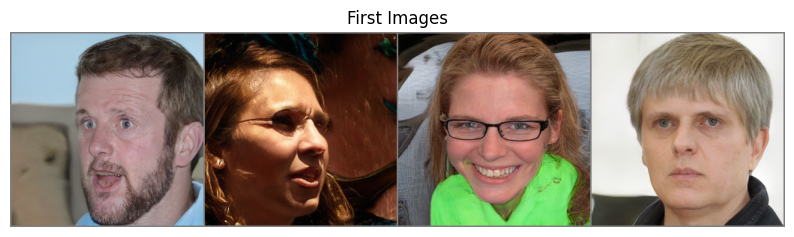

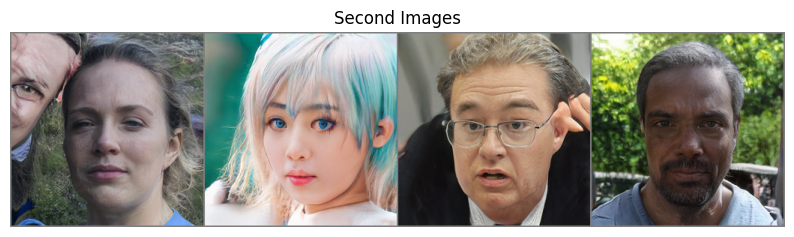

In [11]:
# Sample Generation
sample_z = torch.randn(4, 512, device=device)
sample_z2 = torch.randn(4, 512, device=device)
out, _ = generator([sample_z])
out2, _ = generator([sample_z2])

# Visualize
plt.figure(figsize=(10, 10))
imgshow(torchvision.utils.make_grid(out.detach().cpu(), nrow=4), title='First Images')
imgshow(torchvision.utils.make_grid(out2.detach().cpu(), nrow=4), title='Second Images')

<Figure size 1000x1000 with 0 Axes>

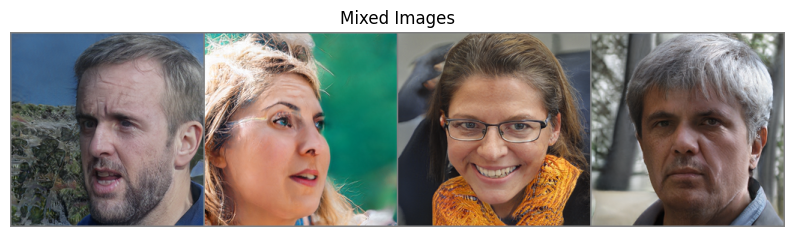

In [12]:
style_mixed, _ = generator([sample_z, sample_z2], inject_index=6)
plt.figure(figsize=(10, 10))
imgshow(torchvision.utils.make_grid(style_mixed.detach().cpu(), nrow=4), title='Mixed Images')

In [13]:
del style_mixed, out, out2

In [14]:
interpolation_rate = [0.2,0.4,0.6,0.8,1]

result1, _ = generator([sample_z])
result2, _ = generator([sample_z2])

In [15]:
result = result1
for alpha in interpolation_rate:
    interpolated = (1-alpha) * sample_z + alpha *sample_z2
    out_interpolated, _ = generator([interpolated])
    result = torch.cat((result, out_interpolated), dim=0)

In [16]:
out_interpolated.shape

torch.Size([4, 3, 256, 256])

<Figure size 1500x3000 with 0 Axes>

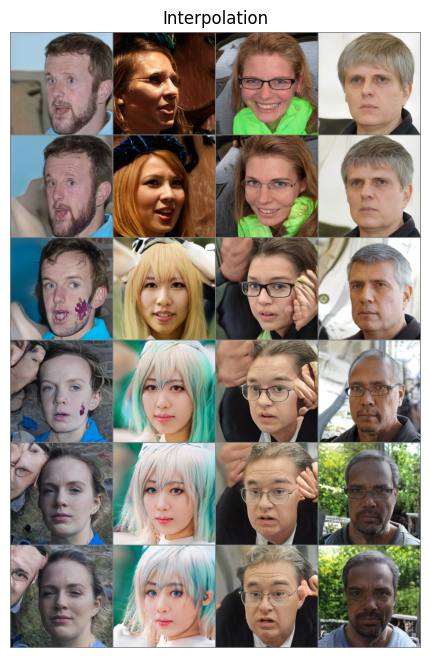

In [17]:
plt.figure(figsize=(15, 30))
imgshow(torchvision.utils.make_grid(result.detach().cpu(), nrow=4), title='Interpolation')